# Create dataset of expressions for training similar-expressions model

## Using custom generator (based on NeSymRes and DLSM code)

Creates .txt file with string expressions.

In [324]:
# from importlib import reload
# from custom import utils, generator, dclasses
# reload(generator)
# reload(utils)
# reload(dclasses)
from utils import create_generator
import os
import numpy as np
np.random.seed(2)

gen, params = create_generator('./data_settings.json')
# gen.generate_equation(np.random, -1e3, 1e3, simplify=False, check_const_range=True)

# Generate data
N = int(1e4)
expressions = [gen.generate_equation(np.random, -1, 1, simplify=False, check_const_range=True) for _ in range(N)]

In [227]:
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'

# Filter out empty strings
expressions = [expr for expr in expressions if expr]

# Save
output_file = os.path.join(datapath, 'expr_240809_1.txt')
with open(output_file, 'w') as f:
    for expr in expressions:
        f.write(f"{expr}\n")

## Parse string to onehot representation

### Whole dataset

In [7]:
import pandas as pd
import h5py
from parsing import parse_dataset
from model.grammar import GCFG

In [4]:
# Load data
datapath = r'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data/expr_240807_5.txt'
with open(datapath, 'r') as f:
    eqs = f.readlines()
    eqs = [eq.strip('\n') for eq in eqs]

# Parse dataset
syntax, invalid, consts = parse_dataset(eqs)

# Save parsed dataset
with h5py.File(f'{datapath[:-4]}-parsed.h5', 'w') as f:
    f.create_dataset('data', data=syntax)
    f.create_dataset('invalid_indices', data=invalid)

In [ ]:
a = [float(const) for const_list in consts for const in const_list]
s = pd.Series(a)
s.describe()

In [2]:
from importlib import reload
from model import util
reload(util)
from model.util import plot_onehot

plot_onehot(syntax[3, ...], GCFG)

ModuleNotFoundError: No module named 'model'

## Create function value dataset

In [2]:
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

In [150]:
from model.util import load_raw_parsed_data

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
name = 'expr_240807_5'
eqs, syntax = load_raw_parsed_data(datapath, name)

In [68]:
import sympy as sp

MAX_ABS_VAL = 1e5

x = np.linspace(-10, 10, 100)
y = np.empty((len(eqs), len(x)))

import multiprocess as mp

def process_equation(args):
    eq, x = args
    expr = sp.sympify(eq)
    return [expr.evalf(subs={sp.Symbol('x1'): val}) for val in x]


with mp.Pool() as pool:
    results = pool.map(process_equation, [(eq, x) for eq in eqs])

y = np.array(results).astype(np.float32)

invalid = np.any(np.isinf(y) | (np.abs(y) > MAX_ABS_VAL), axis=1)
invalid.sum() / len(invalid)

values = y[~invalid]


In [153]:
import h5py

# Save parsed dataset
with h5py.File(f'{datapath}/{name}-values.h5', 'w') as f:
    f.create_dataset('data', data=values)
    f.create_dataset('invalid_mask', data=invalid)

## Analyse syntax data

In [149]:
from util import load_raw_parsed_value_data
import pandas as pd
import numpy as np

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
eqs, syntax, values = load_raw_parsed_value_data(datapath, 'expr_240807_5')

In [231]:
prod_idx = syntax[:, :, :-1].argmax(axis=-1)

unique_rows, counts = np.unique(prod_idx, axis=0, return_counts=True)
print(f"Number of unique rows: {len(unique_rows)}")
res = sorted(zip(unique_rows, counts), key=lambda x: x[1], reverse=True)

for row, count in res[:10]:
    print(f"Row: {row}, Count: {count}")

Number of unique rows: 4288
Row: [ 4  6  4  7  4  6  4  8 10 10 10 10 10 10 10], Count: 313
Row: [ 4  6  4  6  4  7  4  9 10 10 10 10 10 10 10], Count: 309
Row: [ 4  6  4  7  4  7  4  9 10 10 10 10 10 10 10], Count: 299
Row: [ 4  7  4  7  4  6  4  9 10 10 10 10 10 10 10], Count: 297
Row: [ 4  7  4  7  4  7  4  9 10 10 10 10 10 10 10], Count: 296
Row: [ 4  7  4  7  4  6  4  8 10 10 10 10 10 10 10], Count: 292
Row: [ 4  6  4  7  4  7  4  8 10 10 10 10 10 10 10], Count: 291
Row: [ 4  6  4  6  4  6  4  9 10 10 10 10 10 10 10], Count: 284
Row: [ 4  6  4  6  4  6  4  8 10 10 10 10 10 10 10], Count: 280
Row: [ 4  6  4  6  4  7  4  8 10 10 10 10 10 10 10], Count: 271


In [291]:
from util import logits_to_prods, prods_to_eq
from grammar import GCFG
import torch


# Print 5 expressions with the same production
n = 54
for i in np.where(np.all(prod_idx == res[n][0], axis=1))[0][:5]:
    prods = logits_to_prods(torch.tensor(syntax[i].squeeze()), GCFG)
    eq = prods_to_eq(prods)
    print(eq)
    

sin( sin( x1 ) ) + ( -0.21919918060302734 )
sin( sin( x1 ) ) + ( -0.1242685317993164 )
sin( sin( x1 ) ) + ( -0.8278886079788208 )
sin( sin( x1 ) ) + ( -0.044821858406066895 )
sin( sin( x1 ) ) + ( -0.3588927984237671 )


In [306]:
# Print expressions from each unique production

for n in range(20):
    i = np.where(np.all(prod_idx == res[n][0], axis=1))[0][0]
    prods = logits_to_prods(torch.tensor(syntax[i].squeeze()), GCFG, insert_const=False)
    eq = prods_to_eq(prods)
    print(n, '\t', eq)

0 	 sin( exp( sin( x1 ) ) )
1 	 sin( sin( exp( [CONST] ) ) )
2 	 sin( exp( exp( [CONST] ) ) )
3 	 exp( exp( sin( [CONST] ) ) )
4 	 exp( exp( exp( [CONST] ) ) )
5 	 exp( exp( sin( x1 ) ) )
6 	 sin( exp( exp( x1 ) ) )
7 	 sin( sin( sin( [CONST] ) ) )
8 	 sin( sin( sin( x1 ) ) )
9 	 sin( sin( exp( x1 ) ) )
10 	 exp( sin( sin( x1 ) ) )
11 	 exp( sin( exp( [CONST] ) ) )
12 	 sin( exp( sin( [CONST] ) ) )
13 	 exp( sin( exp( x1 ) ) )
14 	 exp( sin( sin( [CONST] ) ) )
15 	 sin( sin( x1 ) ) + x1
16 	 exp( sin( x1 ) + x1 )
17 	 x1 * exp( sin( x1 ) )
18 	 exp( sin( x1 + x1 ) )
19 	 sin( sin( x1 * x1 ) )


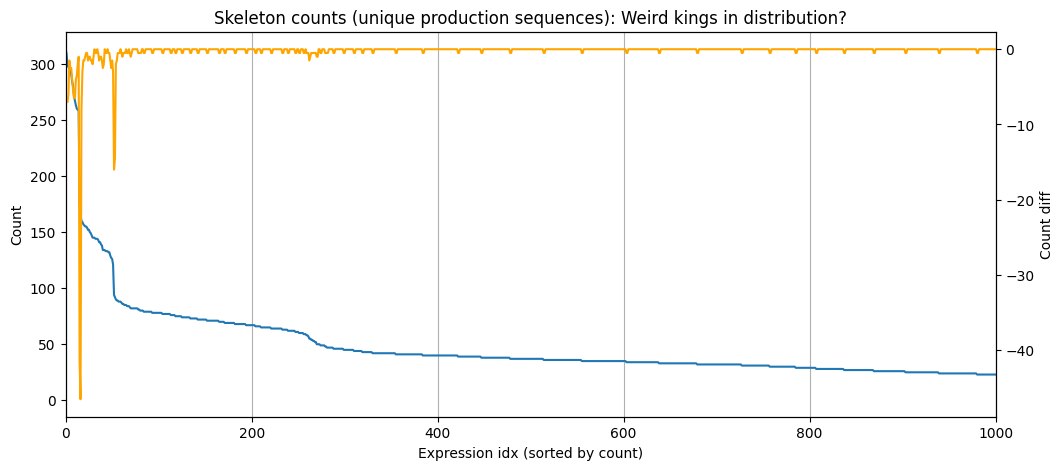

In [319]:
from matplotlib import pyplot as plt

counts_sorted = np.sort(counts)[::-1]

fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(counts_sorted)
ax2 = plt.twinx()
ax2.plot(pd.Series(counts_sorted).diff().rolling(window=2).mean(), color='orange')

ax.set_xlabel('Expression idx (sorted by count)')
ax.set_ylabel('Count')
ax2.set_ylabel('Count diff')
plt.xlim(0, 1000)
# plt.xlim(1000, len(res))
# ax.set_ylim(0, 50)
ax.grid(axis='x')
plt.title('Skeleton counts (unique production sequences): Weird kings in distribution?')
plt.show()

In [177]:
prod_counts = pd.Series(syntax[:, :, :-1].argmax(axis=-1).flatten()).value_counts()
labels = {i: str(prod) for i, prod in enumerate(GCFG.productions())}
prod_counts.index = prod_counts.index.map(labels)
prod_counts

Nothing -> None      338244
S -> T               309605
T -> '(' S ')'       125298
T -> '[CONST]'       119103
T -> 'x1'            117190
S -> S '+' T          76804
S -> S '*' T          75369
T -> 'sin(' S ')'     56325
T -> 'exp(' S ')'     43862
Name: count, dtype: int64

## Analyse function value data

Use this to decide on value transformation

In [3]:
from util import load_raw_parsed_value_data
import pandas as pd
import numpy as np

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
eqs, syntax, values = load_raw_parsed_value_data(datapath, 'expr_240807_5')
x = np.linspace(-10, 10, 100)

In [4]:
a = pd.Series(values.flatten())
a.describe()

count    8.412000e+06
mean     1.089742e+02
std      1.567060e+03
min     -9.844108e+04
25%     -5.092065e-01
50%      4.271007e-01
75%      2.682249e+00
max      9.959591e+04
dtype: float64

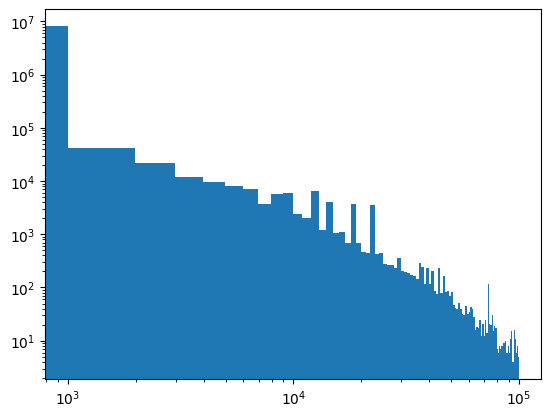

In [5]:
from matplotlib import pyplot as plt

plt.hist(a.abs(), bins=100)
plt.yscale('log')
plt.xscale('log')

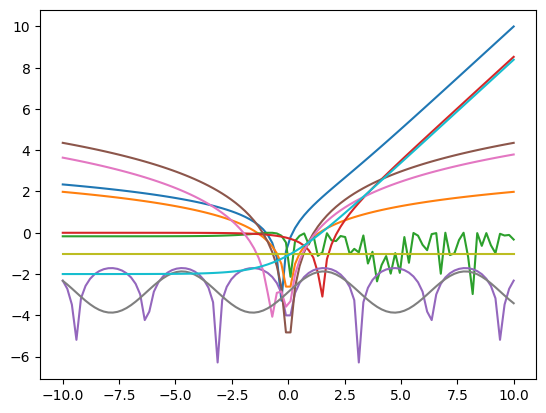

In [8]:
# Example function
plt.plot(x, np.log(np.abs(values[:10, :].T)))

In [96]:
import util
from importlib import reload
reload(util)
from util import load_data
import torch

def value_transform(x):
    eps = 1e-10
    return torch.log(torch.abs(x) + eps)/10  # Example transformation


datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
train_loader, test_loader = load_data(datapath, 'expr_240807_5', test_split=0.1, batch_size=int(1e5), value_transform=value_transform)

_, _, _, y_values = next(iter(train_loader))
x = np.linspace(-10, 10, 100)

In [97]:
pd.Series(y_values.flatten()).describe()

count    7.570800e+06
mean     4.076056e-02
std      2.773862e-01
min     -2.302585e+00
25%     -7.867037e-02
50%      2.616519e-02
75%      1.874362e-01
max      1.150888e+00
dtype: float64

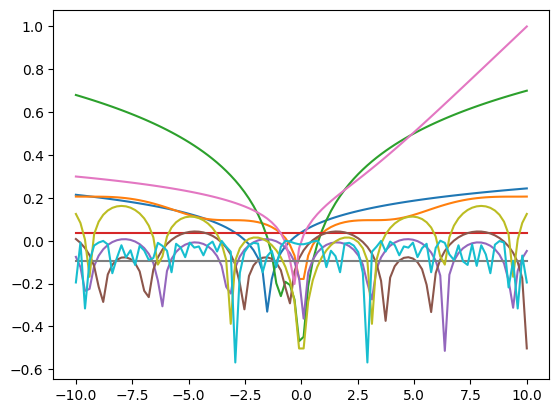

In [103]:
from matplotlib import pyplot as plt

plt.plot(x, y_values[:10, :].T)
plt.show()

## Analyse priors: syntax, constant function value

In [147]:
from util import load_raw_parsed_value_data
import pandas as pd
import numpy as np
from grammar import GCFG

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
eqs, syntax, values = load_raw_parsed_value_data(datapath, 'expr_240807_5')

def value_transform(x):
    eps = 1e-10
    return torch.log(torch.abs(x) + eps)/10  # Example transformation


# Calculate production counts
prod_counts = pd.Series(syntax[:, :, :-1].argmax(axis=-1).flatten()).value_counts()
labels = {i: str(prod) for i, prod in enumerate(GCFG.productions())}
prod_counts.index = prod_counts.index.map(labels)
print(prod_counts)

# Calculate cross entropy prior for syntax
p = prod_counts / prod_counts.sum()
cross_entropy_prior = -np.sum(p * np.log(p))
print(f'\n{cross_entropy_prior = }')

# Calculate MSE prior for constants
consts = syntax[:, :, -1].flatten()
mse_prior_consts = consts.var()
print(f'{mse_prior_consts = }')

# Calculate MSE prior for values
values_transformed = value_transform(torch.tensor(values)).flatten().detach().numpy()
mse_prior_values = values_transformed.var()
print(f'{mse_prior_values = }')

Nothing -> None      338244
S -> T               309605
T -> '(' S ')'       125298
T -> '[CONST]'       119103
T -> 'x1'            117190
S -> S '+' T          76804
S -> S '*' T          75369
T -> 'sin(' S ')'     56325
T -> 'exp(' S ')'     43862
Name: count, dtype: int64

cross_entropy_prior = 1.9647622760005012

mse_prior_consts = 0.031348917125856815

mse_prior_values = 0.07700505140807316
